<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/BMLP_Derfansyah_Guswiranata_Kurnia_clus_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [1]:
#Inisiasi kaggle
!pip install kaggle

In [2]:
#inisiasi file json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derfansyahgk","key":"24be196f622b75f71753aee422847c5c"}'}

In [3]:
#Pengunduhan dataset
!kaggle datasets download -d samuelotiattakorah/agriculture-crop-yield

Dataset URL: https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield
License(s): CC0-1.0
 51% 17.0M/33.4M [00:00<00:00, 169MB/s]
100% 33.4M/33.4M [00:00<00:00, 201MB/s]


In [4]:
#Pembukaan zip
!unzip agriculture-crop-yield.zip

Archive:  agriculture-crop-yield.zip
  inflating: crop_yield.csv          


Ini berguna untuk pengunduhan data kaggle

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [5]:
#Perpustakaan dataset
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#persiapan perpustakaan
from sklearn.preprocessing import RobustScaler
#inspeksi nilai siluet
from sklearn.metrics import silhouette_score

In [7]:
#Persiapan DBSCAN
from sklearn.cluster import DBSCAN
#optimasi fungsi
from joblib import Parallel, delayed

In [8]:
#Perpustakaan yellowbrick, scipy, dan pyclustering
from yellowbrick.cluster import SilhouetteVisualizer
import scipy as sp

In [9]:
!pip install pyclustering

In [9]:
#perpustakaan untuk interpolasi data
from scipy.interpolate import interp1d

In [10]:
#Tetangga terdekat di DBSCAN
from sklearn.neighbors import NearestNeighbors

In [11]:
#inisiasi 'pelabelan banyak' dan 'identifikasi jarak'
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial import distance

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [12]:
#Pengunduhan dataset
cropdf = pd.read_csv('/content/crop_yield.csv')
cropdfc = cropdf.copy()
cropdfc.head(7)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
5,South,Silt,Soybean,797.471182,37.704974,False,True,Rainy,74,5.898416
6,West,Clay,Wheat,357.902357,31.593431,False,False,Rainy,90,2.652392


In [13]:
#Inspeksi Informasi kolom
cropdfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

Latar belakang wilayah

In [14]:
#cek jumlah nilai kolom non numerik
regcount = cropdfc['Region'].value_counts().copy() #total wilayah
stypcou = cropdfc['Soil_Type'].value_counts().copy() #hasil tanah
cropcount = cropdfc['Crop'].value_counts().copy() #hasil
fercount = cropdfc['Fertilizer_Used'].value_counts().copy() #Kepastian Pemakaian pupuk
iricount = cropdfc['Irrigation_Used'].value_counts().copy() #Kepastian sumber air
weatcount = cropdfc['Weather_Condition'].value_counts().copy() #Kepastian cuaca
#cek hasil dalam df
print(f'ada {regcount} wilayah')
print(f'ada {stypcou} jenis tanah')
print(f'ada {cropcount} jenis tanaman')
print(f'ada {fercount} jenis pupuk')
print(f'ada {iricount} jenis sumber air')

ada Region
North    250173
West     250074
South    250054
East     249699
Name: count, dtype: int64 wilayah
ada Soil_Type
Sandy     167119
Loam      166795
Chalky    166779
Silt      166672
Clay      166352
Peaty     166283
Name: count, dtype: int64 jenis tanah
ada Crop
Maize      166824
Rice       166792
Barley     166777
Wheat      166673
Cotton     166585
Soybean    166349
Name: count, dtype: int64 jenis tanaman
ada Fertilizer_Used
False    500060
True     499940
Name: count, dtype: int64 jenis pupuk
ada Irrigation_Used
False    500509
True     499491
Name: count, dtype: int64 jenis sumber air


In [15]:
#Bagian 1 Cek tabel pivot wilayah
ogpiv1 = pd.pivot_table(cropdfc, values='Yield_tons_per_hectare', index='Region', columns='Crop', aggfunc='sum').copy() #Salinan saja
rndpiv1 = ogpiv1.round(3)
rndpiv1 #Nilai total

Crop,Barley,Cotton,Maize,Rice,Soybean,Wheat
Region,,,,,,
East,193297.311,194622.578,192720.865,192811.100,194822.444,191725.986
North,194614.220,193455.603,194367.454,194582.259,191604.430,195709.643
South,193780.222,192998.513,193685.478,193828.061,193866.074,194303.564
West,193389.595,193683.625,193521.018,194488.154,193847.324,193746.965


In [16]:
#Cek per jenis tanah
ogpiv1b = pd.pivot_table(cropdfc, values='Yield_tons_per_hectare', index='Region', columns='Soil_Type', aggfunc='sum').copy() #Salinan saja
rndpiv1b = ogpiv1b.round(3)
rndpiv1b

Soil_Type,Chalky,Clay,Loam,Peaty,Sandy,Silt
Region,,,,,,
East,192178.478,193513.148,192548.438,192991.826,195481.316,193287.079
North,194797.472,193412.956,194966.753,193497.814,193210.015,194448.599
South,194145.196,192292.344,194651.673,193605.569,194467.745,193299.385
West,194883.990,193468.450,193605.975,193297.550,193695.404,193725.312


Inspeksi Nilai Rata-rata suhu

In [17]:
#Rata-rata suhu
ogpiv2 = pd.pivot_table(cropdfc, values='Temperature_Celsius', index='Region', columns='Crop', aggfunc=np.mean).copy() #salinan dari asli
rndpiv2 = ogpiv2.round(3)
rndpiv2 #Nlai rata-rata per wilayah

<ipython-input-17-998932dd66d6>:2: FutureWarning: The provided callable <function mean at 0x788e893bd000> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ogpiv2 = pd.pivot_table(cropdfc, values='Temperature_Celsius', index='Region', columns='Crop', aggfunc=np.mean).copy() #salinan dari asli


Crop,Barley,Cotton,Maize,Rice,Soybean,Wheat
Region,,,,,,
East,27.442,27.505,27.465,27.555,27.523,27.530
North,27.467,27.531,27.470,27.510,27.477,27.520
South,27.541,27.512,27.470,27.455,27.526,27.513
West,27.554,27.561,27.506,27.475,27.510,27.502


In [18]:
#pemeriksaan kecendrungan dari grafik
kolnum = cropdfc.iloc[:,[3,4,8,9]].copy() #numerikal
kolnum.head(6)

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
0,897.077239,27.676966,122,6.555816
1,992.673282,18.026142,140,8.527341
2,147.998025,29.794042,106,1.127443
3,986.866331,16.644190,146,6.517573
4,730.379174,31.620687,110,7.248251
5,797.471182,37.704974,74,5.898416


Text(0, 0.5, 'Hasil (tons per hectare)')

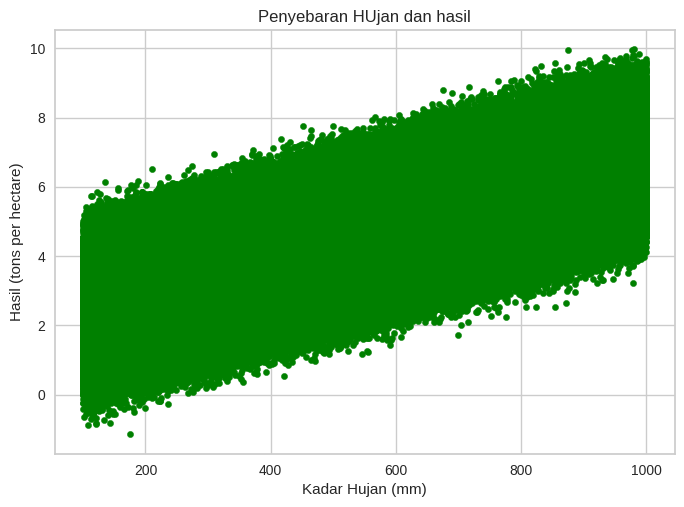

In [19]:
#cek penyebaran
bx = cropdfc.plot.scatter(x='Rainfall_mm', y='Yield_tons_per_hectare', title='Penyebaran HUjan dan hasil', color='green')
bx.set_xlabel('Kadar Hujan (mm)')
bx.set_ylabel('Hasil (tons per hectare)')

<ipython-input-20-74134e0db2fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grp = sns.boxplot(x='Fertilizer_Used', y='Yield_tons_per_hectare', data=cropdfc, palette="Set2", showfliers=True)


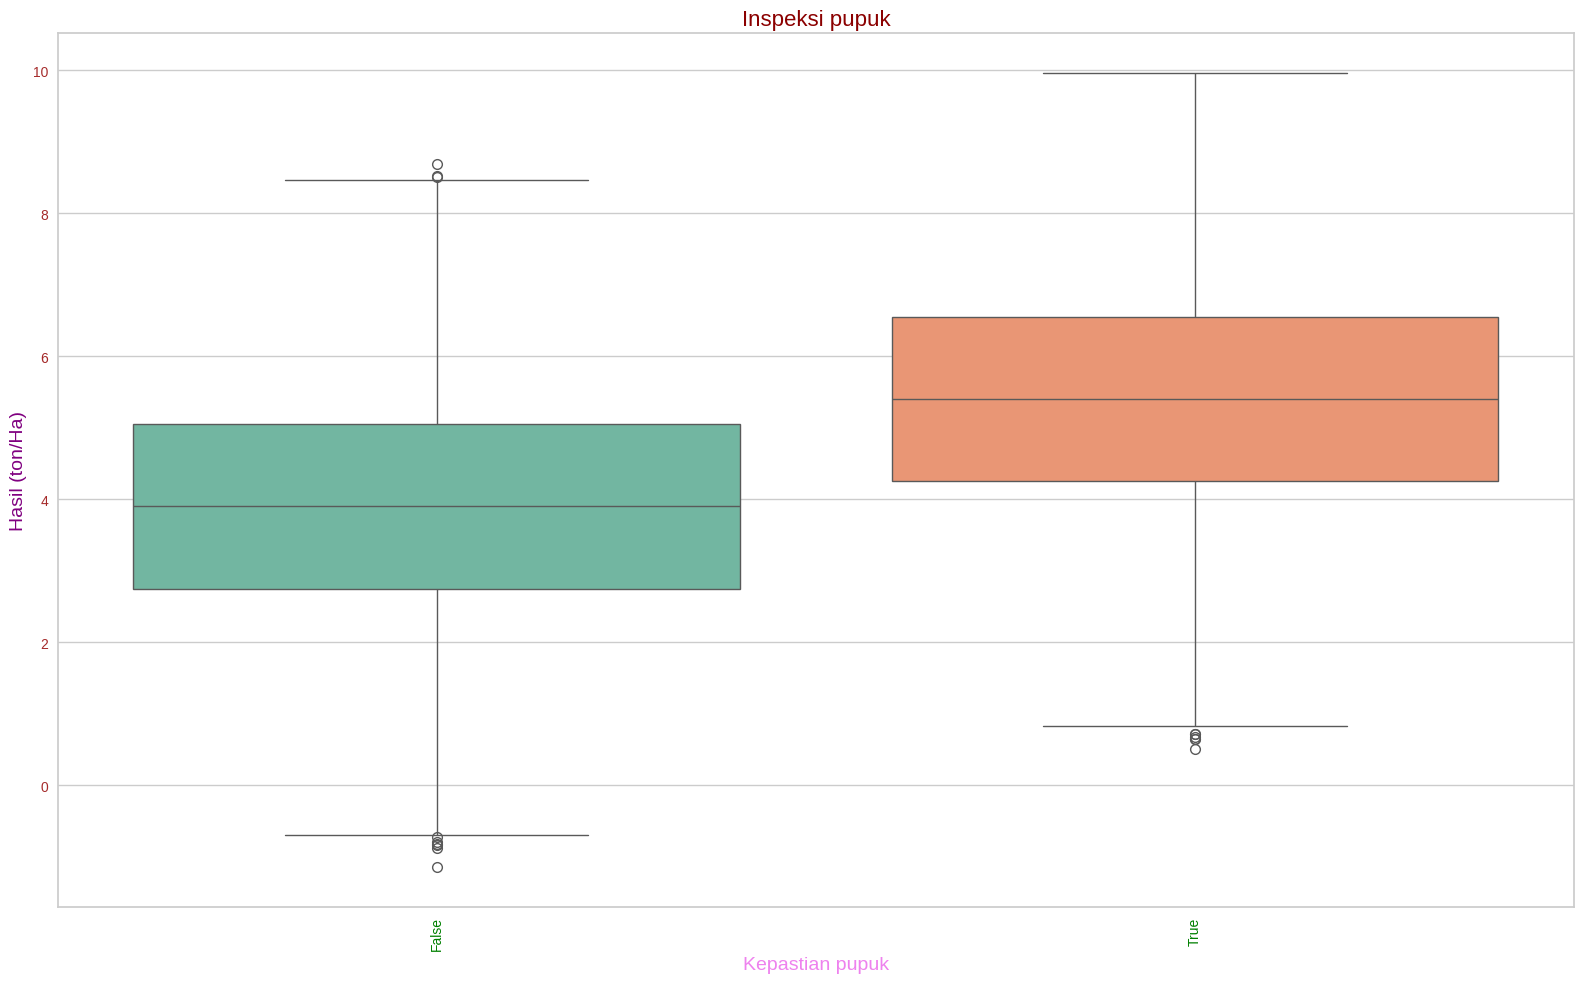

In [20]:
#grafik kotak untuk inspeksi kolom
plt.figure(figsize=(16, 10)) #ukuran besar
grp = sns.boxplot(x='Fertilizer_Used', y='Yield_tons_per_hectare', data=cropdfc, palette="Set2", showfliers=True)
#penyetelan
grp.set_title('Inspeksi pupuk', fontsize=16, color='darkred')
grp.set_xlabel('Kepastian pupuk', fontsize=14, color='violet')
grp.set_ylabel('Hasil (ton/Ha)', fontsize=14, color='purple')

#Pewarnaan
plt.xticks(rotation=90, color='green')  # Sumbu X
plt.yticks(color='brown') #Sumbu y

# Ilustrasi
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [21]:
#Cek kolom kosong
cropdfc.isna().sum()

,0
Region,0
Soil_Type,0
Crop,0
Rainfall_mm,0
Temperature_Celsius,0
Fertilizer_Used,0
Irrigation_Used,0
Weather_Condition,0
Days_to_Harvest,0
Yield_tons_per_hectare,0


In [22]:
#cek kolom hilang
cropdfc.isnull().sum()

,0
Region,0
Soil_Type,0
Crop,0
Rainfall_mm,0
Temperature_Celsius,0
Fertilizer_Used,0
Irrigation_Used,0
Weather_Condition,0
Days_to_Harvest,0
Yield_tons_per_hectare,0


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [23]:
#Segmentasi kluster (non numerik)
regtyp = cropdfc['Region'].unique().copy() #Wilayah
soiltyp = cropdfc['Soil_Type'].unique().copy() #Tanah
croptyp = cropdfc['Crop'].unique().copy() #Tanaman
fertyp = cropdfc['Fertilizer_Used'].unique().copy() #Kespatian ada Pupuk
irrttyp = cropdfc['Irrigation_Used'].unique().copy() #Kespatian ada Sumber Air
weatttyp = cropdfc['Weather_Condition'].unique().copy() #Kespatian ada Cuaca
#ke pemeriksaan hasil

In [24]:
#cek pemeriksaan hasil
print(f'ada {regtyp} jenis wilayah') # wilayah
print(f'ada {soiltyp} jenis tanah') # tanah
print(f'ada {croptyp} jenis tanaman') # jenis tanaman
print(f'ada {fertyp} kepastian pupuk') #kepastian pupuk
print(f'ada {irrttyp} kepastian sumber air') #kepastian sumber air
print(f'ada {weatttyp} kepastian cuaca') #kepastian cuaca

ada ['West' 'South' 'North' 'East'] jenis wilayah
ada ['Sandy' 'Clay' 'Loam' 'Silt' 'Peaty' 'Chalky'] jenis tanah
ada ['Cotton' 'Rice' 'Barley' 'Soybean' 'Wheat' 'Maize'] jenis tanaman
ada [False  True] kepastian pupuk
ada [ True False] kepastian sumber air
ada ['Cloudy' 'Rainy' 'Sunny'] kepastian cuaca


In [25]:
#Persiapan mlb untuk kolom non numerik
mlb_reg = MultiLabelBinarizer() #Wilayah
mlb_soil = MultiLabelBinarizer() #Jenis Tanah
mlb_crop = MultiLabelBinarizer() #Panen
mlb_wea = MultiLabelBinarizer() #Cuaca
lb = LabelBinarizer() #Kepastian Pupuk dan Irigasi
#pengubahan kolom non numerik dengan mlb
regmlb = mlb_reg.fit_transform(cropdfc['Region']) #Wilayah
soilmlb = mlb_soil.fit_transform(cropdfc['Soil_Type']) #Jenis Tanah
cropmlb = mlb_crop.fit_transform(cropdfc['Crop']) #Panen
weamlb = mlb_wea.fit_transform(cropdfc['Weather_Condition']) #Cuaca
#Pakai label binarizer
irrmlb = lb.fit_transform(cropdfc['Irrigation_Used'])
fermlb = lb.fit_transform(cropdfc['Fertilizer_Used'])

### Hal yang diperhatikan
* Ada dua kolom dengan pemakaian 'LB'
* ada empat kolom dengan pemakaian 'MLB'

In [26]:
#Pengubahan hasil ke df non numerik (label binarizer)
irrmlbdf = pd.DataFrame(irrmlb, columns=['Kepastian Irigasi']) #Kepastian irigasi
fermlbdf = pd.DataFrame(fermlb, columns=['Kepastian Pupuk']) #Kepastian pupuk
#Kolom dengan 'MLB'
regmlbdf = pd.DataFrame(regmlb, columns=mlb_reg.classes_) #Wilayah
soilmlbdf = pd.DataFrame(soilmlb, columns=mlb_soil.classes_) #Jenis tanah
cropmlbdf = pd.DataFrame(cropmlb, columns=mlb_crop.classes_) #Hasil panen
weamlbdf = pd.DataFrame(weamlb, columns=mlb_wea.classes_)  # Cuaca

In [27]:
#Pengembalian hasil non numerik
dfbknumer = pd.concat([irrmlbdf, fermlbdf, regmlbdf, soilmlbdf, cropmlbdf, weamlbdf], axis=1)
dfbknumer.head(6) #cek 6 baris dahulu

,Kepastian Irigasi,Kepastian Pupuk,E,N,S,W,a,e,h,o,...,R,S,a,d,i,l,n,o,u,y
0,1,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,1,0,1,1,1
1,1,1,0,0,1,0,0,0,1,1,...,1,0,1,0,1,0,1,0,0,1
2,0,0,0,1,0,0,0,0,1,1,...,0,1,0,0,0,0,1,0,1,1
3,1,0,0,1,0,0,0,0,1,1,...,1,0,1,0,1,0,1,0,0,1
4,1,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,1,0,1,1,1
5,1,0,0,0,1,0,0,0,1,1,...,1,0,1,0,1,0,1,0,0,1


Ada 60 kolom (2 dari Hasil LB)

In [28]:
#Persiapan df untuk Hasil robust scaler di kolom numerik
scaler = RobustScaler()
#persiapan konversi ke robust
kolnumsca = scaler.fit_transform(kolnum)
#Pengubahan ke df
kolnumscadf = pd.DataFrame(kolnumsca, columns=kolnum.columns)
#cek hasil
kolnumscadfsamp = kolnumscadf.head(6)
print(kolnumscadfsamp) #Lihat hasil

   Rainfall_mm  Temperature_Celsius  Days_to_Harvest  Yield_tons_per_hectare
0     0.771269             0.013569         0.400000                0.773496
1     0.983776            -0.758573         0.800000                1.574420
2    -0.893916             0.182952         0.044444               -1.431759
3     0.970868            -0.869140         0.933333                0.757959
4     0.400703             0.329098         0.133333                1.054795
5     0.549847             0.815889        -0.666667                0.506430


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [29]:
#Penyatuan hasil DF untuk persiapan DBSCAN
dbscandf = pd.concat([kolnumscadf, dfbknumer], axis=1) #Usahakan benar
dbscandfsamp = dbscandf.head(6) #sampel
print(dbscandf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 64 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Rainfall_mm             1000000 non-null  float64
 1   Temperature_Celsius     1000000 non-null  float64
 2   Days_to_Harvest         1000000 non-null  float64
 3   Yield_tons_per_hectare  1000000 non-null  float64
 4   Kepastian Irigasi       1000000 non-null  int64  
 5   Kepastian Pupuk         1000000 non-null  int64  
 6   E                       1000000 non-null  int64  
 7   N                       1000000 non-null  int64  
 8   S                       1000000 non-null  int64  
 9   W                       1000000 non-null  int64  
 10  a                       1000000 non-null  int64  
 11  e                       1000000 non-null  int64  
 12  h                       1000000 non-null  int64  
 13  o                       1000000 non-null  int64  
 14  r  

In [30]:
#Inspeksi nilai epsilon dan minimal pts (demi nilai minimal 0.55 syukur-syukur 0.7)
def calculate_k_distances(data):
    """Calculate k-distances for determining optimal epsilon."""
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    return np.sort(distances[:, 1])

def evaluate_dbscan(data, eps, min_samples):
    """Evaluate DBSCAN with given parameters."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    if len(set(labels)) > 1:  # At least two clusters
        return silhouette_score(data, labels), labels
    return -1, None  # No valid clustering found

def find_optimal_dbscan_params(data, eps_range):
    """Find optimal DBSCAN parameters using parallel evaluation."""
    distances = calculate_k_distances(data)

    best_score = -1
    best_params = (None, None)
    best_labels = None

    total_samples = data.shape[0]
    min_samples_range = range(2, max(2, total_samples // 100))

    # Parallel evaluation
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_dbscan)(data, eps, min_samples)
        for min_samples in min_samples_range
        for eps in eps_range
    )

    # Collecting results and checking scores
    index = 0
    for min_samples in min_samples_range:
        for eps in eps_range:
            score, labels = results[index]
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

            # Check if the score is between 0.55 and 0.70
            if 0.55 <= best_score < 0.70:
                print(f"Score of {best_score:.2f} found with epsilon: {eps} and min_samples: {min_samples}")

            # Stop evaluation if score reaches or exceeds 0.70
            if best_score >= 0.70:
                print(f"Score of {best_score:.2f} exceeds threshold of 0.70 with epsilon: {eps} and min_samples: {min_samples}")
                return best_params, best_labels

            index += 1

    return best_params, best_labels

In [31]:
#Eksekusi fungsi pencarian parameter terbaik
data = dbscandf.values #Nilai dari df
eps_range = np.arange(0.01, 1.0, 0.005) #Nilai epsilon
#ke eksekusi sesungguhnya

In [ ]:
#Eksekusi sesungguhnya
poinminimal = find_optimal_dbscan_params(data, eps_range) #ada dua komponen
#cek hasil
print(f'Optimal eps: {poinminimal[0]}, Optimal minPts: {poinminimal[1]}')

In [ ]:
#Eksekusi DBSCAN


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Visualisasi Normal
def visualize_clusters(data, labels):
    """Visualize clusters using PCA."""
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))

    # Scatter plot of PCA results colored by cluster labels
    unique_labels = set(labels)

    for label in unique_labels:
        if label == -1:  # Noise points
            color = 'k'  # Black for noise
        else:
            color = plt.cm.jet(label / len(unique_labels))  # Color map for clusters

        plt.scatter(reduced_data[labels == label, 0], reduced_data[labels == label, 1], color=color, label=f'Cluster {label}')

    plt.title('PCA of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
#Visualisasi dengan 'seleksi fitur'


## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [ ]:
#Pengunduhan ke csv